# Проект №4. RDS. Кредитный рейтинг.

[проект на kaggle](https://www.kaggle.com/laysanmart/project-5-scoring-v2-laysan)

### Задача: построить модель кредитного скоринга для вторичных клиентов

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LogisticRegression 

from sklearn.preprocessing import PolynomialFeatures 

from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier


import re
import datetime
from datetime import datetime, timedelta
from itertools import combinations 
from scipy.stats import ttest_ind 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler 

import warnings; warnings.simplefilter('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
#с учебной страницы курса
from pandas import Series
import pandas as pd #есть
import numpy as np #есть

import matplotlib.pyplot as plt #есть
import seaborn as sns #есть

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, log_loss #дополнила log_loss
from sklearn.metrics import auc, roc_auc_score, roc_curve #метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #метрики

from sklearn.model_selection import GridSearchCV #для гиперпараметров


In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
# тренировочный (train, используется для обучения модели)
df_train = pd.read_csv('train.csv')
# тестовый (test, используется для оценки точности модели)
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')


In [5]:
!pip freeze > requirements.txt

In [6]:
#Функция для анализа числовых столбцов
def func1(df, col, with_bins):
    
    #Заменим на NaN если есть пустая строчка     
    df[col] = df[col].apply(lambda x: None if str(x).strip()=='' else x)
    
    #display(pd.DataFrame(df[col].value_counts()))
    print("Значений, встретившихся в столбце", col, "более 10 раз:", (df[col].value_counts()>10).sum())
    print("Уникальных значений:", df[col].nunique())
    df.loc[:, [col]].info()
    
    if with_bins == 1:
    
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])
        axes.hist(df[col], bins = int(df[col].median()),color = 'green') 
        #axes.set_title('Общая сумма счета')
        axes.set_ylabel('Количество')
        axes.set_xlabel(col)  
        
    else: # без bins равному медиане
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])
        axes.hist(df[col], color = 'green')        
        axes.set_ylabel('Количество')
        axes.set_xlabel(col) 

In [7]:
#Функция для анализа квантилей и выбросов
def func_quantile(df, col):   
    
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    IQR = perc75 - perc25
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    
    # Подсчитаем количество выбросов
    print("Количество выбросов в столбце",col,":",df[df[col]<perc25 - 1.5*IQR][col].count() + df[df[col]>perc75 + 1.5*IQR][col].count())
    df[col].loc[df[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 20, label = 'IQR')
    plt.legend()  

In [8]:
#Функция для заполнения выбросов ближайшим квантилем
def filling_quantile(df, col, quant): #quant=0.25 или 0.75
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    IQR = perc75 - perc25
    high_border = perc75 + 1.5*IQR
    low_border = perc25 - 1.5*IQR
    if quant == 0.75:
        df[col] = df[col].apply(lambda x: high_border if x > high_border else x)
    elif quant == 0.25:
        df[col] = df[col].apply(lambda x: low_border if x < low_border else x)
    else:
        print('Значение квантиля должно быть 0.25 или 0.75 :)')


In [9]:
# Считаем метрики модели
def metrics(y_test, probs, y_pred_test):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.rcParams['figure.figsize'] = (8,8)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

    f1_test_n = f1_score(y_test, y_pred_test)
    print('f1 score:=',round(f1_test_n,4))

    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    print('precision: {:.4f}\nrecall: {:.4f}'.format(precision, recall))

    #calc_accuracy(y_test, y_pred_test)
    #acc, TP, TN, P, N = calc_accuracy(y_test, y_pred_test)
    #print('TP = {}\nTN = {}\nP = {}\nN = {}\nacc = {:.4f}'.format(TP, TN, P, N, acc))

    conf_mat = confusion_matrix(y_test, y_pred_test)
    print('Confusion matrix:\n{}'.format(conf_mat))
  #  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=model.classes_)
  #  disp.plot()

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [11]:
df_train.head(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
5,41415,18FEB2014,SCH,M,27,Y,N,0,1,-2.032257,0,50,1,1,15000,2,3,N,0
6,28436,04FEB2014,SCH,M,39,N,N,0,0,-2.225004,0,60,1,2,28000,1,1,N,0
7,68769,17MAR2014,SCH,F,39,N,N,0,0,-1.522739,1,50,2,3,45000,3,3,N,0
8,38424,14FEB2014,SCH,F,50,Y,N,1,0,-1.676061,0,50,1,1,30000,1,4,N,0
9,4496,10JAN2014,UGR,F,54,N,N,0,0,-2.695176,1,50,2,3,24000,1,3,N,0


In [12]:
df_train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [13]:
# Для корректной обработки данных объединим train и test в один датасет
df_train['sample'] = 1 # помечаем train
df_test['sample'] = 0 # помечаем test
df_test['default'] = 0 # # в тесте у нас нет значения дефолта, мы его должны предсказать, по этому пока просто заполняем нулями

df_scoring = df_test.append(df_train, sort=False).reset_index(drop=True)

In [14]:
df_scoring.default.value_counts()

0    100776
1      9372
Name: default, dtype: int64

In [15]:
df_scoring.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
73167,82765,31MAR2014,GRD,F,37,N,N,0,0,-1.546834,1,80,2,3,50000,1,4,N,1,0
19133,44095,20FEB2014,UGR,M,23,N,N,2,0,-2.169664,1,70,2,3,50000,1,1,N,0,0
60,29418,05FEB2014,SCH,F,37,Y,Y,0,0,-2.342409,2,60,2,3,33000,2,2,N,0,0
6025,14166,21JAN2014,SCH,M,30,N,N,1,0,-2.353052,0,70,2,3,31000,4,1,N,0,0
71934,61256,10MAR2014,SCH,F,45,Y,Y,0,1,-1.644032,5,70,1,3,27000,1,2,N,1,0


In [16]:
df_scoring.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.669999,0.085086
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.470215,0.279010
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


<AxesSubplot:>

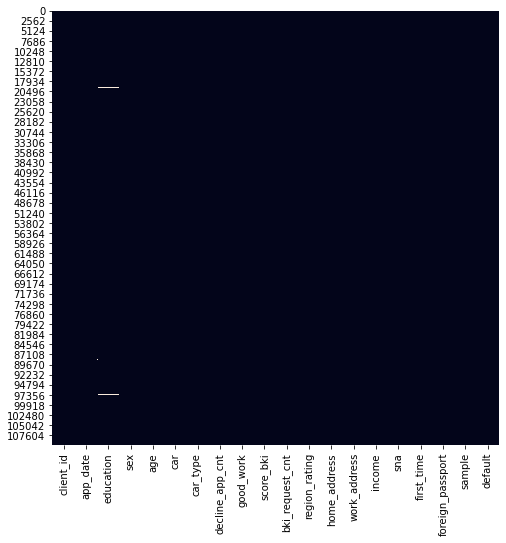

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df_scoring.isnull(), cbar=False)

Посмотрим на данные:

In [18]:
df_scoring.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default'],
      dtype='object')

- client_id - идентификатор клиента
- app_date - дата подачи заявки
-  education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- foreign_passport - наличие загранпаспорта
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- default - флаг дефолта по кредиту


<AxesSubplot:xlabel='default', ylabel='count'>

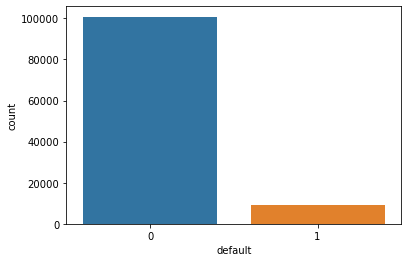

In [19]:
#Построим диаграмму для переменной default. 
sns.countplot(x='default', data=df_scoring)

In [20]:
df_scoring.default.value_counts()

0    100776
1      9372
Name: default, dtype: int64

Клиентов без дефолта у банка больше. Видим, что целевая переменная не сбалансированная.

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [22]:
#посмотрим количество пропусков для каждого признака:
df_scoring.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима предварительная очистка данных.

In [23]:
#бинарные переменные
bin_cols=['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

#категориальные переменные
cat_cols=['education', 'home_address', 'work_address','sna', 'first_time']

#числовые переменные
num_cols=['age', 'decline_app_cnt', 'income', 'bki_request_cnt','score_bki','region_rating']

### Создадим наивную модель

In [24]:
df_scoring_1 = df_scoring.copy()

In [25]:
df_scoring_1.dropna(inplace=True)

In [26]:
df_scoring_1.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [27]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(df_scoring_1['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [28]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df_scoring_1[column] = label_encoder.fit_transform(df_scoring_1[column])
    
# убедимся в преобразовании    
df_scoring_1.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,0


In [29]:
#Попробуем сделать дамми-перемнные для категориальных переменных
#df_scoring_1 = pd.get_dummies(df_scoring_1, columns=['education', 'home_address', 'work_address','sna', 'first_time'], dummy_na=False)

In [30]:
df_scoring_1['education'] = label_encoder.fit_transform(df_scoring_1['education'])
df_scoring_1

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,1,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0
1,17527,24JAN2014,3,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0
2,75683,23MAR2014,4,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0
3,26883,03FEB2014,3,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0
4,28862,04FEB2014,1,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,1,0,45,0,0,0,0,-1.792064,3,50,1,2,17000,4,4,0,1,0
110144,76821,24MAR2014,3,1,41,1,1,0,0,-2.058029,1,50,2,2,70000,1,4,0,1,0
110145,103695,22APR2014,3,1,31,0,0,0,0,-1.512635,4,80,2,3,45000,2,2,0,1,0
110146,861,04JAN2014,3,0,29,0,0,0,1,-1.479334,3,50,1,3,13000,2,3,0,1,1


In [31]:
X_cat  = OneHotEncoder(sparse = False).fit_transform(df_scoring_1[cat_cols].values)

In [32]:
X_num = StandardScaler().fit_transform(df_scoring_1[num_cols].values)

In [33]:
df_scoring_1 = df_scoring_1.drop(['client_id','app_date', 'sample'], axis=1)
df_scoring_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109670 entries, 0 to 110147
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         109670 non-null  int32  
 1   sex               109670 non-null  int32  
 2   age               109670 non-null  int64  
 3   car               109670 non-null  int32  
 4   car_type          109670 non-null  int32  
 5   decline_app_cnt   109670 non-null  int64  
 6   good_work         109670 non-null  int64  
 7   score_bki         109670 non-null  float64
 8   bki_request_cnt   109670 non-null  int64  
 9   region_rating     109670 non-null  int64  
 10  home_address      109670 non-null  int64  
 11  work_address      109670 non-null  int64  
 12  income            109670 non-null  int64  
 13  sna               109670 non-null  int64  
 14  first_time        109670 non-null  int64  
 15  foreign_passport  109670 non-null  int32  
 16  default           10

In [34]:
X = np.hstack([X_num, df_scoring_1[bin_cols].values, X_cat])
Y = df_scoring_1['default'].values

In [35]:
#Разбиваем выборку на обучающую и тестовую и обучаем нашу модель:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [36]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

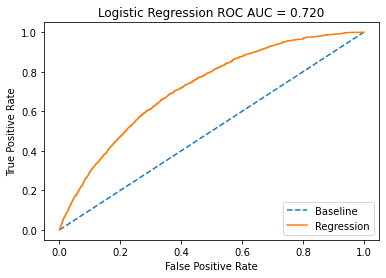

In [37]:
#Вычисляем метрики:

probs = model.predict_proba(X_test)
probs = probs[:,1]
Y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [38]:
# ROC AUC = 0.72, уже?

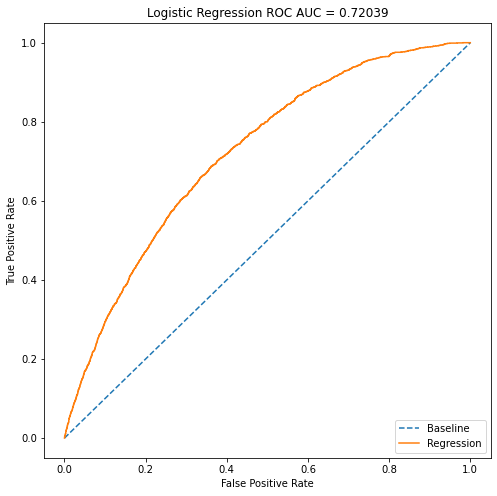

f1 score:= 0.0107
precision: 0.4167
recall: 0.0054
Confusion matrix:
[[20067    14]
 [ 1843    10]]


In [39]:
metrics(y_test, probs, Y_pred)

In [40]:
# при этом остальные метрики выклядят не очень хорошо, а судя по матрице ошибок, мы угадали  примерно 99,9% клиентов со 
# значением дефолта 0 и 0,54% клиентов с дефолтом. Это из-за того, что выборка несбалансирована, дефолтных клиетов 
# намного меньше

In [41]:
log_loss(y_test,Y_pred)

2.9241597045551733

## Рассмотрим и проанализируем числовые переменные в колонках num_cols

In [42]:
#num_cols=['age','decline_app_cnt','income','bki_request_cnt']

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. 

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

<AxesSubplot:>

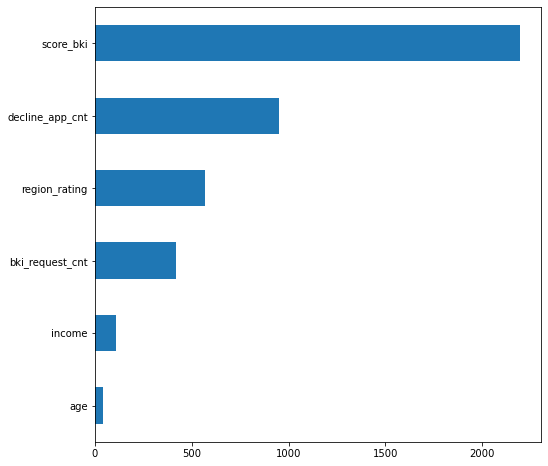

In [43]:
imp_num = pd.Series(f_classif(df_scoring[num_cols], df_scoring['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Вывод: Самый значимый признак из числовых признаков - <b>score_bki</b>

In [44]:
#Посмотрим на распределение числовых данных:

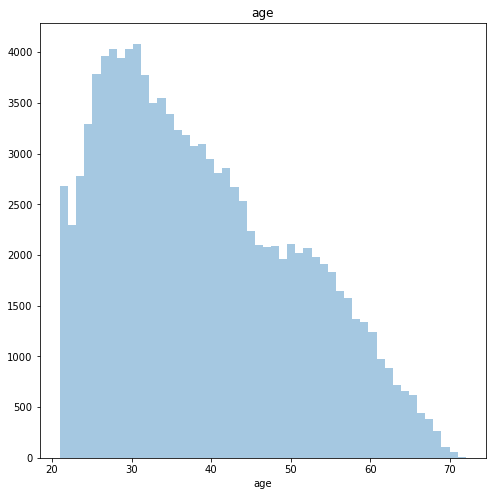

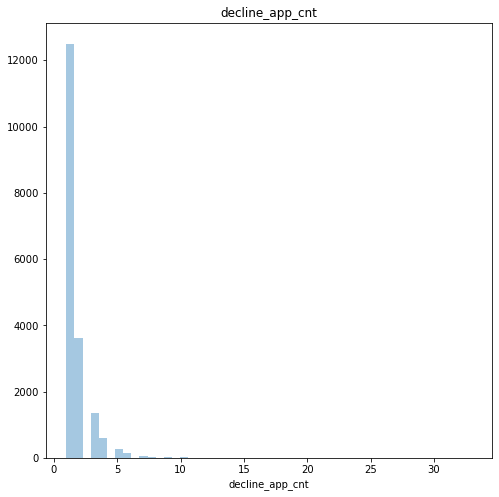

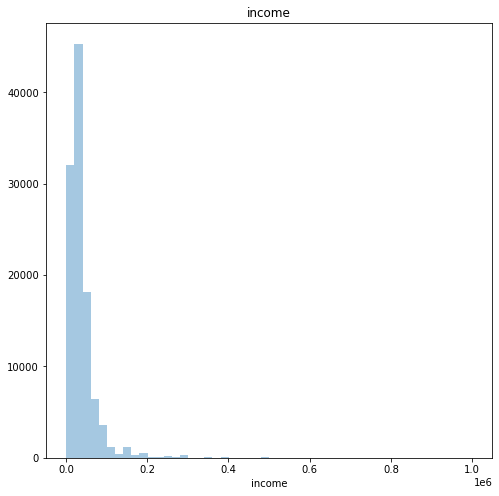

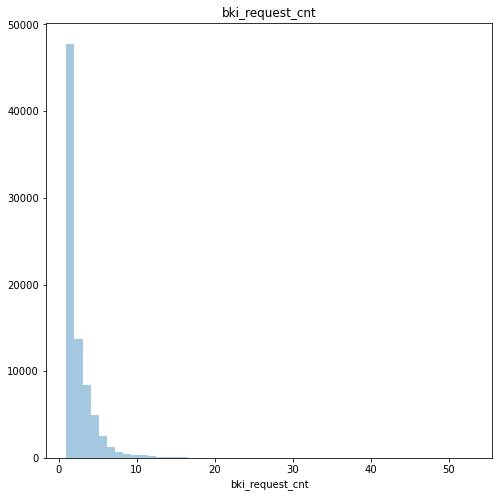

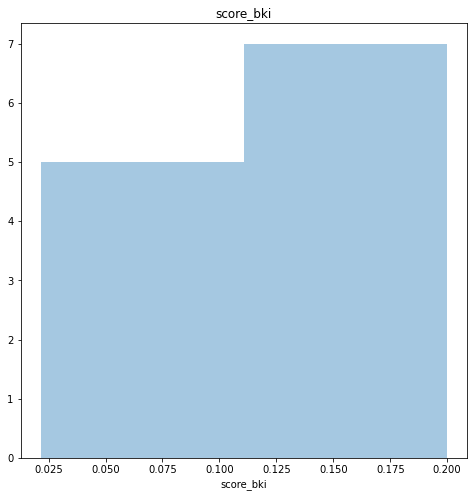

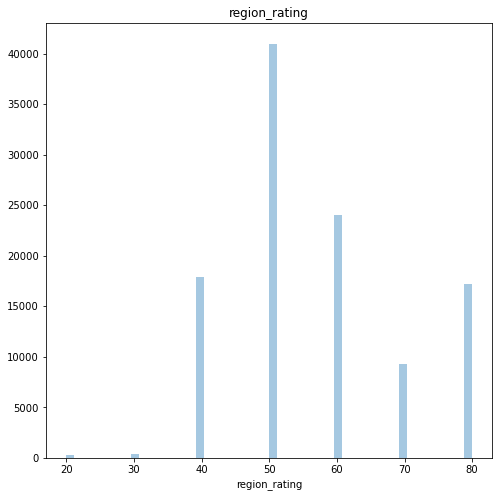

In [45]:
for i in num_cols:
    plt.figure()
    sns.distplot(df_scoring[i][df_scoring[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

#### После построения гистограмм стало очевидно,что распределения всех числовых переменных имеют тяжёлый правый хвост. 

#### Построим графики распределения логарифмированных переменных.

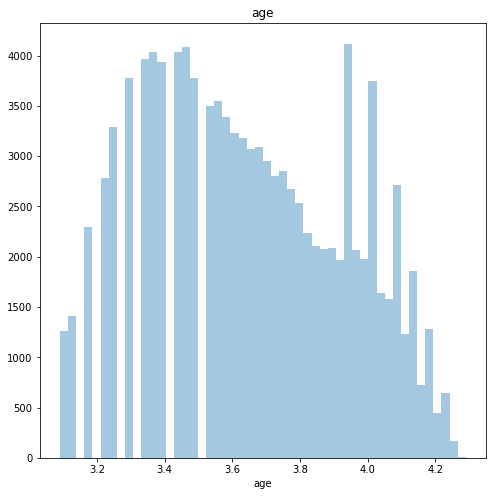

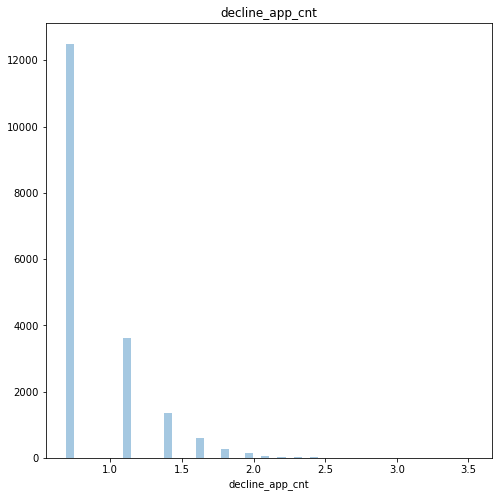

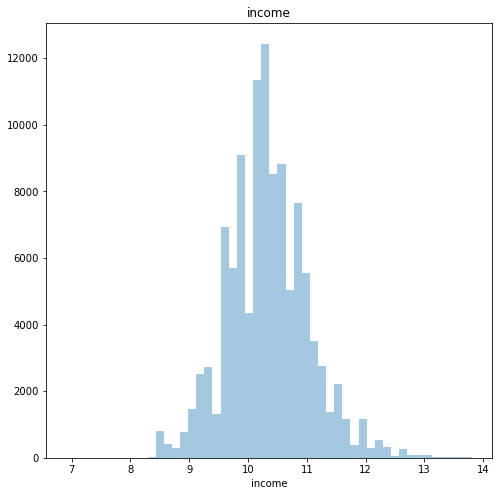

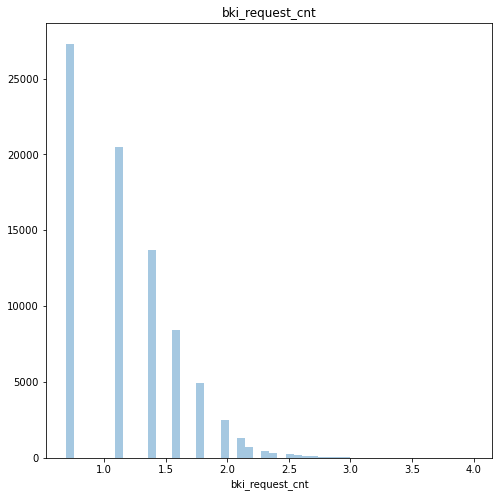

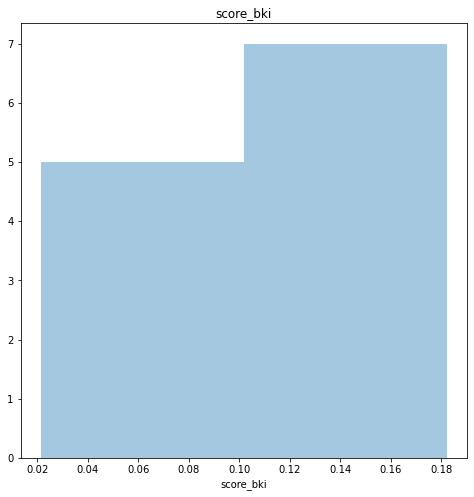

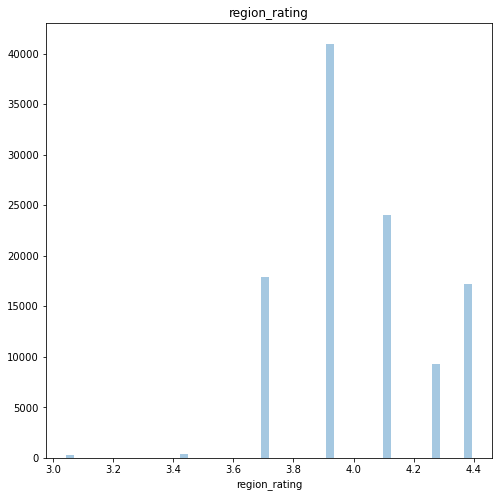

In [46]:
data=df_scoring.copy()
data = data.apply(lambda x: np.log(x+1) if np.issubdtype(x.dtype, np.number) else x)
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

#### Некоторые переменные стали менее смещёнными. Такой принцип можно применить перед построением модели и сравнить значение метрики.

Пройдемся по каждой колонке более детально

### Рассмотрим и проанализируем колонку age

Значений, встретившихся в столбце age более 10 раз: 50
Уникальных значений: 52
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   age     110148 non-null  int64
dtypes: int64(1)
memory usage: 860.7 KB


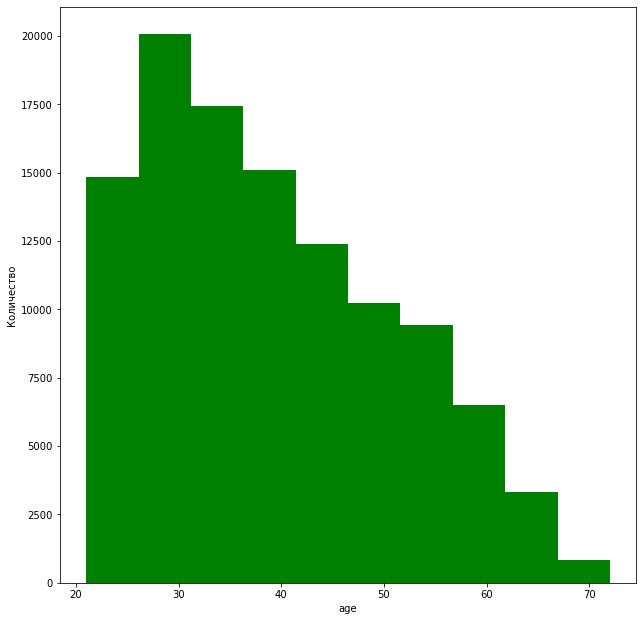

In [47]:
func1(df_scoring,'age',10)

Распределение не являются нормальными и смещено вправо. 
При построении модели необходимо будет выполнить стандартизацию этого численного признака.

25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0,  Границы выбросов: [3.0, 75.0].
Количество выбросов в столбце age : 0


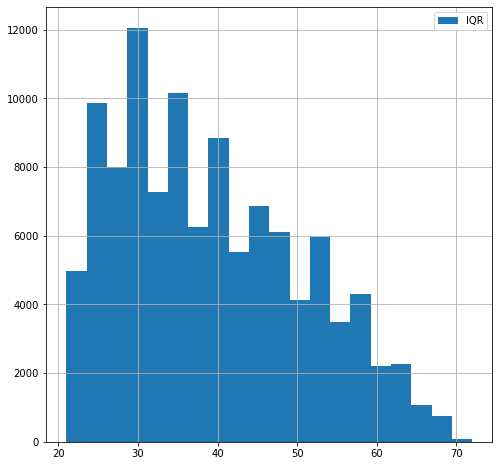

In [48]:
func_quantile(df_scoring,'age')

<AxesSubplot:xlabel='age'>

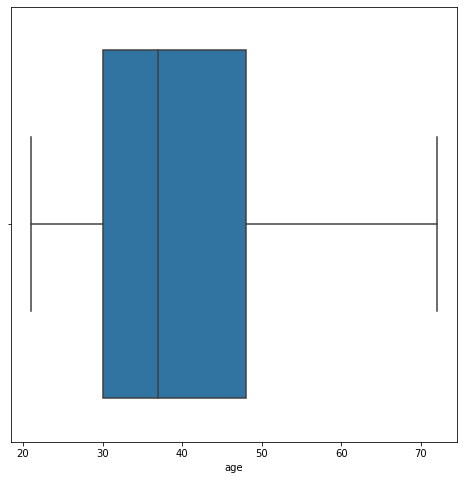

In [49]:

sns.boxplot(x= 'age', data = df_scoring)

default
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

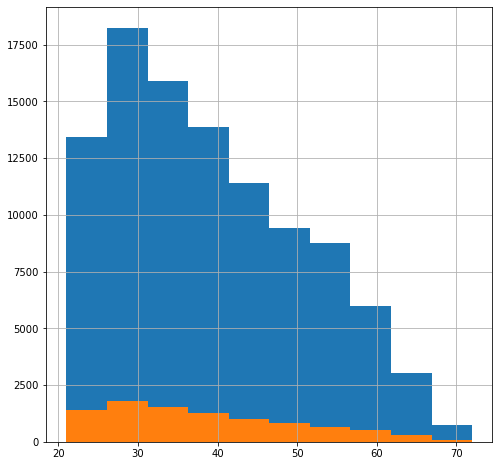

In [50]:
df_scoring.groupby('default')['age'].hist()

In [51]:
df_scoring.groupby(by = ['default'])['age'].median()

default
0    37.0
1    36.0
Name: age, dtype: float64

Дефолтные клиенты в среднем младше, но незначительно

In [52]:
#Посмотрим на корреляцию
df_scoring['default'].corr(df_scoring['age'])

-0.01916936543015275

Корреляция небольшая.

In [53]:
# разделим возраста по группам и посмотрим, что получится
def age_to_cat(age):
    if age <= 28:
        cat_age = 'young'
        return cat_age             
    if 28 < age <= 35:
        cat_age = 'midle-young'
        return cat_age
    if 35 < age <= 50:
        cat_age = 'midle'
        return cat_age
    if age > 50:
        cat_age = 'elderly'
        return cat_age

In [54]:
df_scoring['age_group'] = 0
df_scoring['age_group'] = df_scoring['age'].apply(lambda x:age_to_cat(x))
df_scoring['age_group'] = label_encoder.fit_transform(df_scoring['age_group'])
df_scoring

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,age_group
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,...,50,1,2,50000,1,4,N,0,0,2
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,...,50,1,2,5000,4,3,N,0,0,1
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,...,50,1,2,30000,1,3,Y,0,0,1
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,...,40,1,2,17000,1,3,N,0,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,...,80,2,3,120000,1,3,N,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,...,50,1,2,17000,4,4,N,1,0,1
110144,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,...,50,2,2,70000,1,4,N,1,0,1
110145,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,...,80,2,3,45000,2,2,N,1,0,2
110146,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,...,50,1,3,13000,2,3,N,1,1,2


In [55]:
#Посмотрим на корреляцию
df_scoring['default'].corr(df_scoring['age_group'])

0.020188516289593124

In [56]:
# корреляция не сильно изменилась, позже признак уберем

In [57]:
df_scoring["age_log"] = df_scoring.age.apply(lambda х: np.log(х + 1))

In [58]:
# Нормализуем признак
a_features = df_scoring[['age']].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
df_scoring.loc[:, ['age']] = norm_features

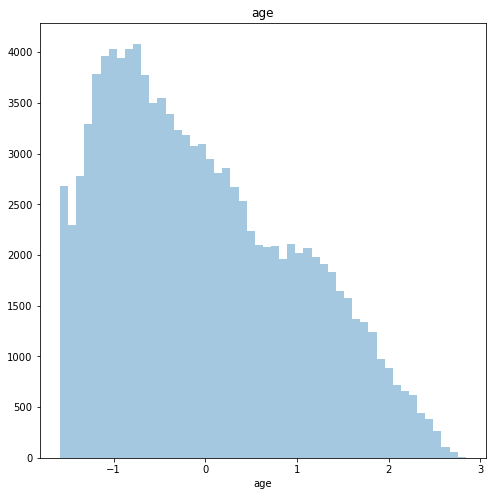

In [59]:
#Проверим, что получилось
plt.figure()
sns.distplot(df_scoring['age'], kde = False, rug=False)
plt.title('age')
plt.show()

### Рассмотрим и проанализируем колонку decline_app_cnt

In [60]:
#decline_app_cnt - количество отказанных прошлых заявок

Значений, встретившихся в столбце decline_app_cnt более 10 раз: 11
Уникальных значений: 24
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   decline_app_cnt  110148 non-null  int64
dtypes: int64(1)
memory usage: 860.7 KB


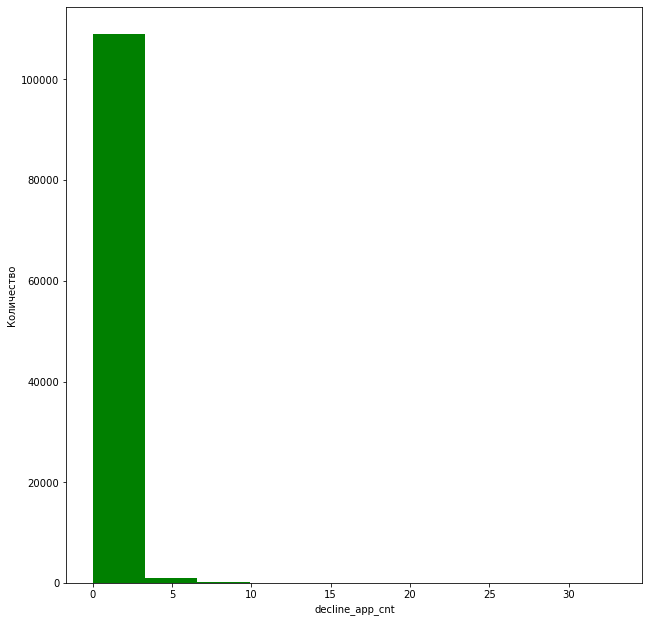

In [61]:
func1(df_scoring,'decline_app_cnt',10)

<AxesSubplot:xlabel='default'>

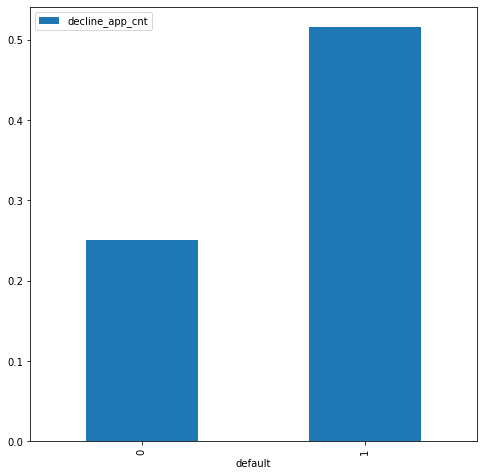

In [62]:
df_scoring.pivot_table(values = ['decline_app_cnt'], 
               index = 'default', 
               aggfunc = 'mean').plot(kind = 'bar')

In [63]:
df_scoring.groupby('default')['decline_app_cnt'].mean()

default
0    0.250675
1    0.515472
Name: decline_app_cnt, dtype: float64

Дефолтные клиенты в среднем имеют большое количество отмененных заявок

In [64]:
#Посмотрим на корреляцию
df_scoring['default'].corr(df_scoring['decline_app_cnt'])

0.09245536420330973

In [65]:
#Попробуем нормализацию MinMaxScaler
scaler = MinMaxScaler()
Ranking_norm = scaler.fit_transform(df_scoring.loc[:,['decline_app_cnt']]) 
df_scoring.loc[:, ['decline_app_cnt']] = Ranking_norm

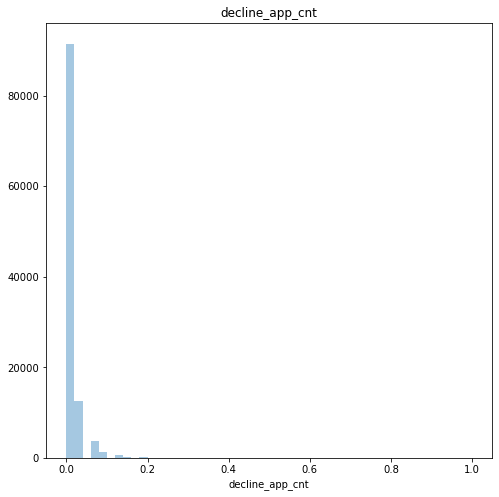

In [66]:
#Проверим, что получилось
plt.figure()
sns.distplot(df_scoring['decline_app_cnt'], kde = False, rug=False)
plt.title('decline_app_cnt')
plt.show()

In [67]:
df_scoring["decline_log"] = df_scoring.decline_app_cnt.apply(lambda ч: np.log(ч + 1))

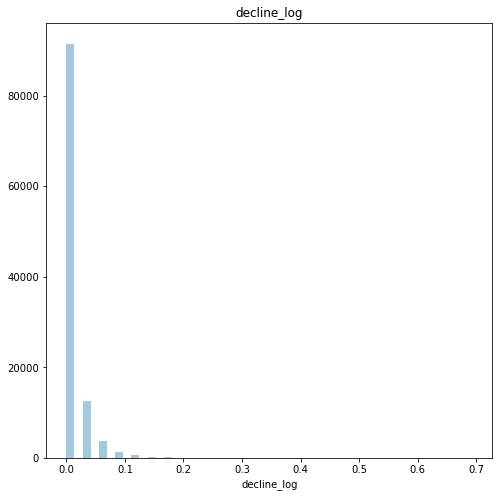

In [68]:
#Проверим, что получилось
plt.figure()
sns.distplot(df_scoring['decline_log'], kde = False, rug=False)
plt.title('decline_log')
plt.show()

### Рассмотрим и проанализируем колонку income

In [69]:
#income - доход заёмщика

Значений, встретившихся в столбце income более 10 раз: 218
Уникальных значений: 1207
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   income  110148 non-null  int64
dtypes: int64(1)
memory usage: 860.7 KB


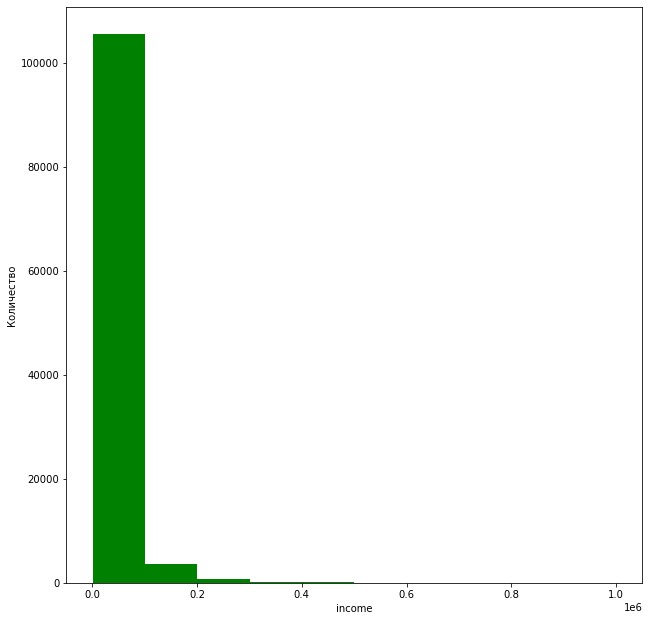

In [70]:
func1(df_scoring,'income',10)

In [71]:
df_scoring.groupby('default')['income'].mean()

default
0    41452.022436
1    36288.113316
Name: income, dtype: float64

Дефолтные клиенты в среднем имеют более низкий доход

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Количество выбросов в столбце income : 7000


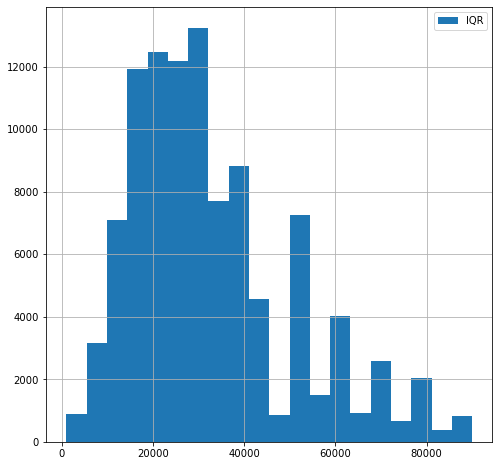

In [72]:
func_quantile(df_scoring,'income')

In [73]:
#Заменим выбросы ближайшим квантилем
filling_quantile(df_scoring,'income', 0.75)

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Количество выбросов в столбце income : 0


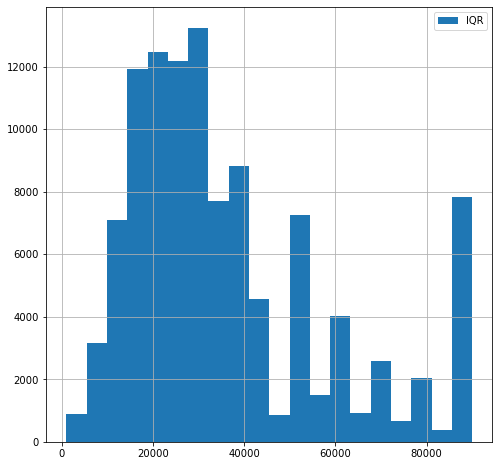

In [74]:
func_quantile(df_scoring,'income')

In [75]:
df_scoring["income_log"] =  data["income"]# логарифмированные данные

Text(0.5, 0, 'income_log')

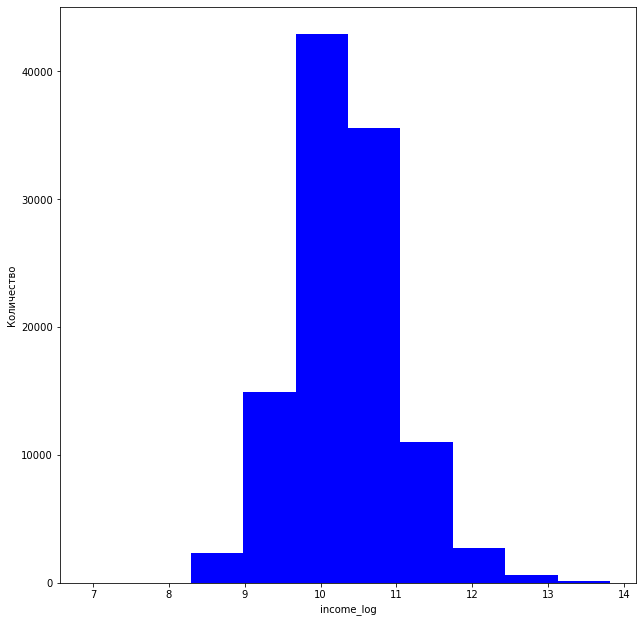

In [76]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df_scoring['income_log'], color = 'blue')        
axes.set_ylabel('Количество')
axes.set_xlabel('income_log') 

Распределение стало больше похоже на нормальное

In [77]:
#Посмотрим на корреляцию
df_scoring['default'].corr(df_scoring['income'])

-0.04851463539428162

Корреляция слабая

### Рассмотрим и проанализируем колонку bki_request_cnt

In [78]:
#bki_request_cnt - количество запросов в БКИ

Значений, встретившихся в столбце bki_request_cnt более 10 раз: 24
Уникальных значений: 40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   bki_request_cnt  110148 non-null  int64
dtypes: int64(1)
memory usage: 860.7 KB


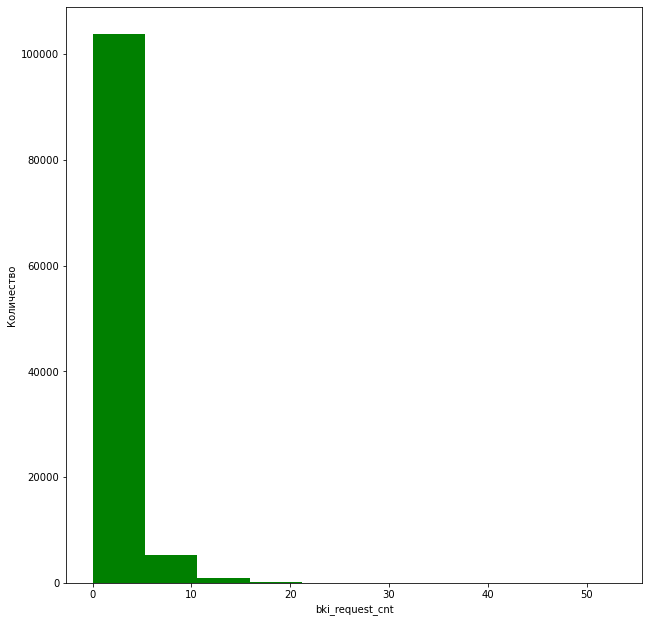

In [79]:
func1(df_scoring,'bki_request_cnt',10)

<AxesSubplot:xlabel='default'>

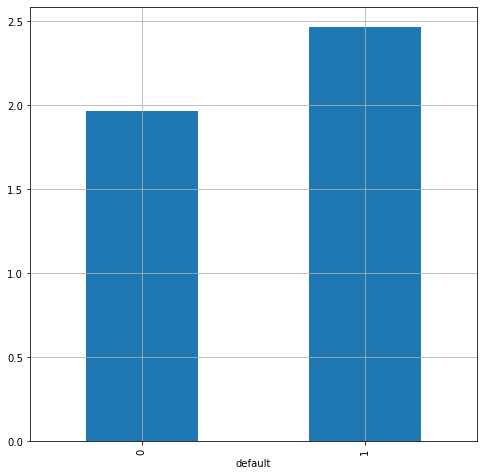

In [80]:
df_scoring.groupby(by = ['default'])['bki_request_cnt'].mean().plot(kind = 'bar', grid= True)

25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Количество выбросов в столбце bki_request_cnt : 2636


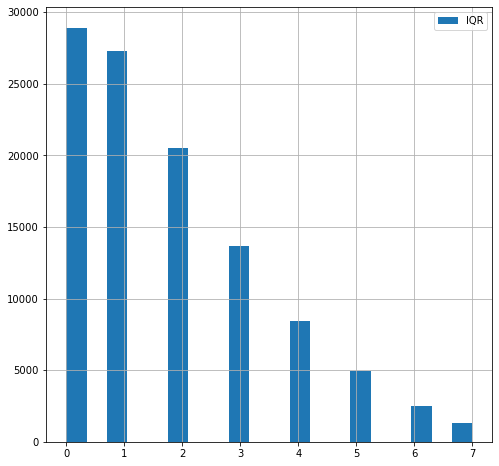

In [81]:
func_quantile(df_scoring,'bki_request_cnt')

In [82]:
df_scoring["bki_request_cnt_log"] = df_scoring.bki_request_cnt.apply(lambda х: np.log(х + 1))

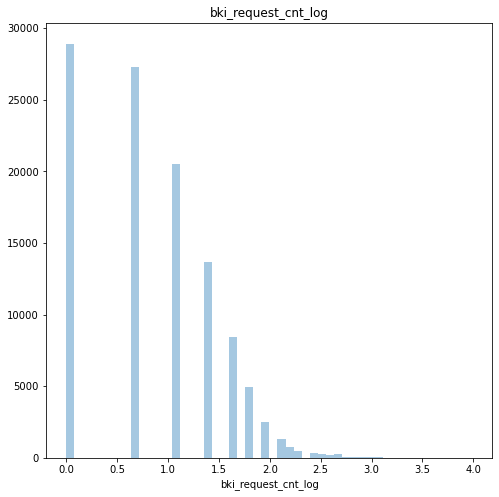

In [83]:
#Проверим, что получилось
plt.figure()
sns.distplot(df_scoring['bki_request_cnt_log'], kde = False, rug=False)
plt.title('bki_request_cnt_log')
plt.show()

Корреляция низкая

### Рассмотрим и проанализируем колонку score_bki

In [84]:
# score_bki - скоринговый балл по данным из БКИ

Значений, встретившихся в столбце score_bki более 10 раз: 92
Уникальных значений: 102618
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   score_bki  110148 non-null  float64
dtypes: float64(1)
memory usage: 860.7 KB


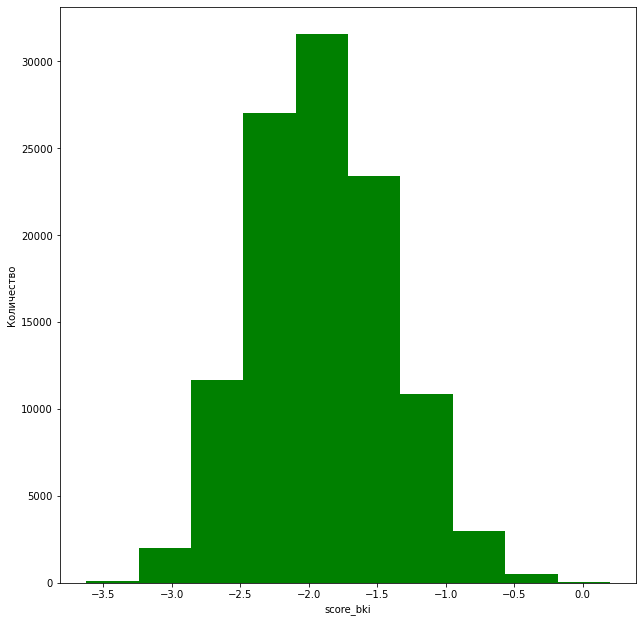

In [85]:
func1(df_scoring,'score_bki',10)

Распределение близкое к нормальному

25-й перцентиль: -2.2604336700000003, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Количество выбросов в столбце score_bki : 518


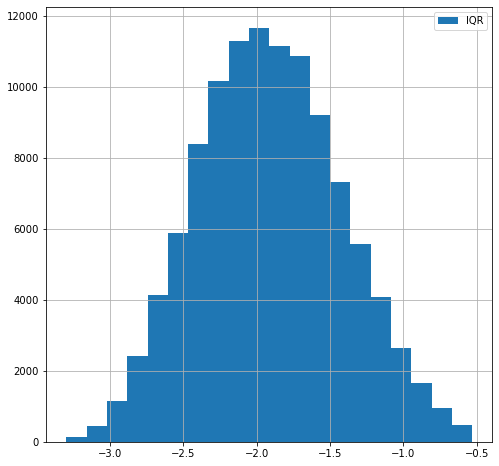

In [86]:
func_quantile(df_scoring,'score_bki')

In [87]:
#Посмотрим на корреляцию
df_scoring['default'].corr(df_scoring['score_bki'])

0.13977679490097578

Корреляция низкая

### Рассмотрим и проанализируем колонку region_rating

In [88]:
# region_rating - рейтинг региона

Значений, встретившихся в столбце region_rating более 10 раз: 7
Уникальных значений: 7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   region_rating  110148 non-null  int64
dtypes: int64(1)
memory usage: 860.7 KB


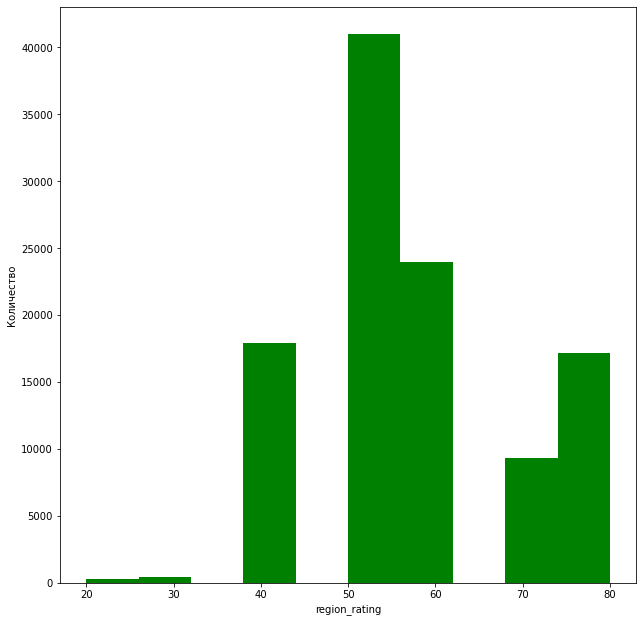

In [89]:
func1(df_scoring,'region_rating',10)

25-й перцентиль: 50.0, 75-й перцентиль: 60.0, IQR: 10.0,  Границы выбросов: [35.0, 75.0].
Количество выбросов в столбце region_rating : 17917


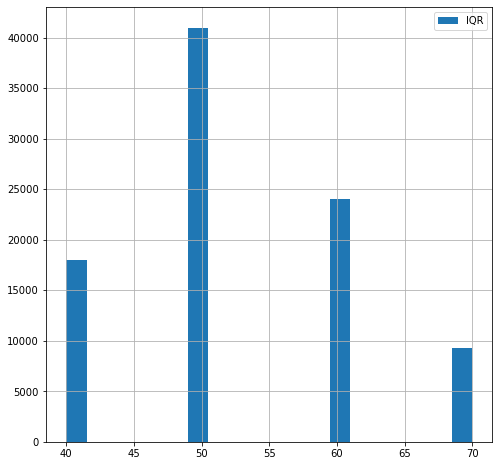

In [90]:
func_quantile(df_scoring,'region_rating')

<AxesSubplot:xlabel='region_rating'>

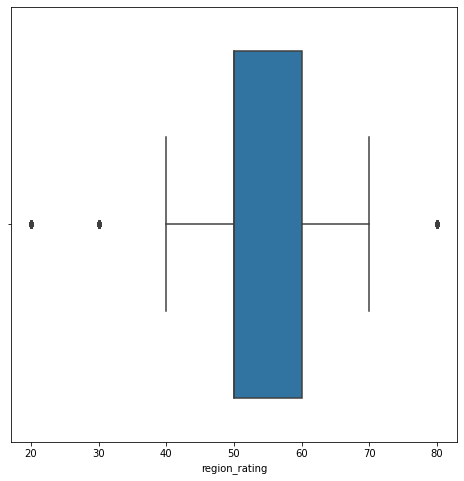

In [91]:
sns.boxplot(x= 'region_rating', data = df_scoring)

default
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: region_rating, dtype: object

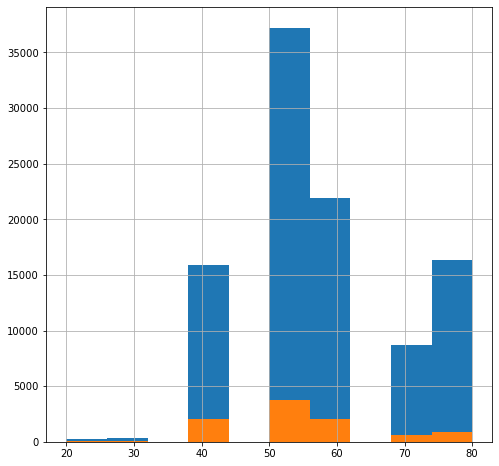

In [92]:
df_scoring.groupby('default')['region_rating'].hist()

<AxesSubplot:xlabel='default'>

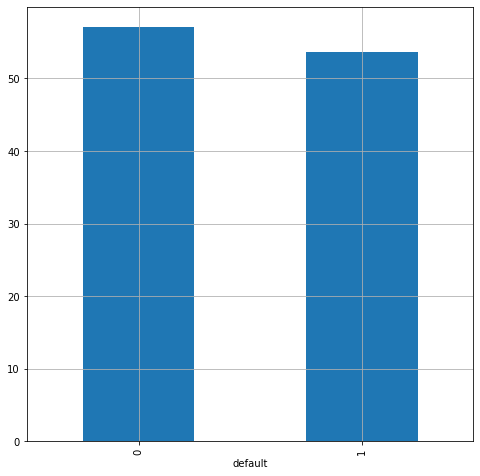

In [93]:
df_scoring.groupby(by = ['default'])['region_rating'].mean().plot(kind = 'bar', grid= True)

In [94]:
df_scoring.groupby(by = ['default'])['region_rating'].mean()

default
0    57.036993
1    53.677977
Name: region_rating, dtype: float64

Среднее значение рейтинга городов ниже у дефолтных клиентов

In [95]:
#Посмотрим на корреляцию
df_scoring['default'].corr(df_scoring['region_rating'])

-0.07172854694953619

In [96]:
df_scoring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   client_id            110148 non-null  int64  
 1   app_date             110148 non-null  object 
 2   education            109670 non-null  object 
 3   sex                  110148 non-null  object 
 4   age                  110148 non-null  float64
 5   car                  110148 non-null  object 
 6   car_type             110148 non-null  object 
 7   decline_app_cnt      110148 non-null  float64
 8   good_work            110148 non-null  int64  
 9   score_bki            110148 non-null  float64
 10  bki_request_cnt      110148 non-null  int64  
 11  region_rating        110148 non-null  int64  
 12  home_address         110148 non-null  int64  
 13  work_address         110148 non-null  int64  
 14  income               110148 non-null  float64
 15  sna              

In [97]:
num_cols=['age', 'decline_app_cnt', 'income', 'bki_request_cnt','score_bki','region_rating', 'age_group', 
          'age_log', 'decline_log', 'income_log', 'bki_request_cnt_log']

<AxesSubplot:>

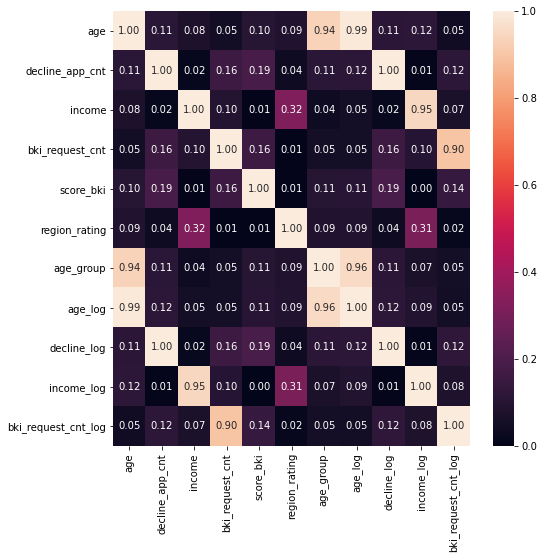

In [98]:
sns.heatmap(df_scoring[num_cols].corr().abs(), vmin=0, vmax=1,annot=True, fmt=".2f",)

Большие корреляции между связынными признаками, далее посмотрим, какие из них лучше убрать, а какие оставить
Как мы видим, взаимосвязь пар остальных числовых признаков по Пирсону слабая. Максимальный коэффициент 0.31. Это очень здорово для нашей модели. 

Text(0.5, 1.0, 'Significance of num variables')

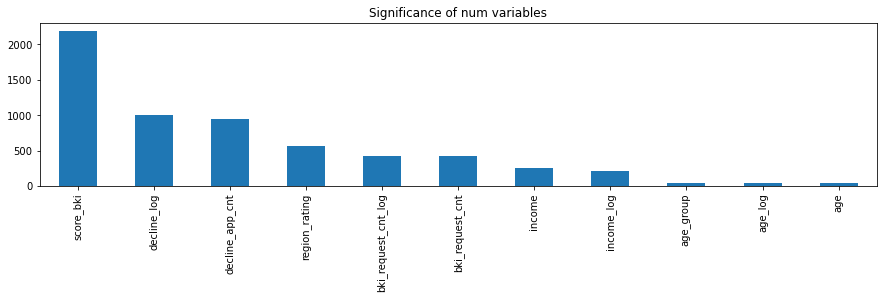

In [99]:
num_cols = pd.Series(
    f_classif(
        df_scoring[num_cols],
        df_scoring["default"],
    )[0],
    index=num_cols,
)
num_cols.sort_values(inplace=True, ascending=False)
num_cols.plot(kind="bar", figsize=(15, 3))
plt.title("Significance of num variables")

In [100]:
num_cols=['income','score_bki','region_rating', 'age_group', 'decline_log', 'bki_request_cnt_log']

In [101]:
df_scoring.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,sna,first_time,foreign_passport,sample,default,age_group,age_log,decline_log,income_log,bki_request_cnt_log
0,74835,22MAR2014,GRD,M,-0.889859,Y,Y,0.000000,0,-2.271884,...,1,4,N,0,0,2,3.401197,0.000000,10.819798,1.386294
1,17527,24JAN2014,SCH,F,-0.021654,N,N,0.151515,0,-1.504999,...,4,3,N,0,0,1,3.688879,0.141079,8.517393,1.098612
2,75683,23MAR2014,UGR,M,0.933372,Y,Y,0.000000,0,-1.691339,...,1,3,Y,0,0,1,3.931826,0.000000,10.308986,0.693147
3,26883,03FEB2014,SCH,M,1.454295,N,N,0.000000,0,-2.374182,...,1,3,N,0,0,0,4.043051,0.000000,9.741027,0.693147
4,28862,04FEB2014,GRD,F,-0.108474,N,N,0.000000,0,-2.487502,...,1,3,N,0,0,1,3.663562,0.000000,11.695255,0.000000


### Рассмотрим и проанализируем колонку app_date

In [102]:
#app_date- дата подачи заявки 

#Преобразуем дату 
df_scoring['app_date'] = pd.to_datetime(df_scoring['app_date'])
#добавим после преобразования эту колонку в num_cols
num_cols.append('app_date')

In [103]:
# Добавим данные из дат
df_scoring['day']= df_scoring['app_date'].apply(lambda x: datetime.weekday(x))
df_scoring['month']= df_scoring['app_date'].map(lambda x: x.month)
df_scoring['year']= df_scoring['app_date'].map(lambda x: x.year)
#генерируем признак - давность заявки
df_scoring['date_diff']= df_scoring['app_date'].apply(lambda x: (datetime.today()-x).days )

<AxesSubplot:>

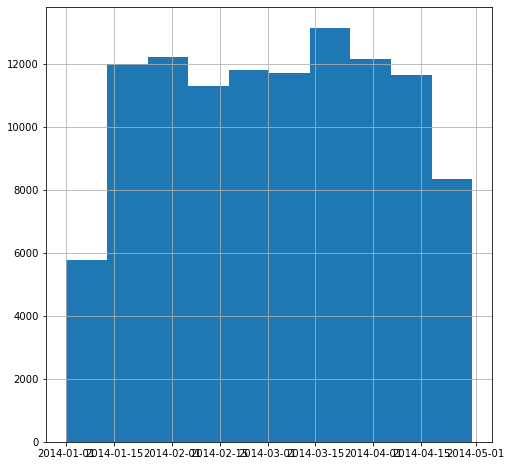

In [104]:
df_scoring.app_date.hist()

In [105]:
df_scoring.sample()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,default,age_group,age_log,decline_log,income_log,bki_request_cnt_log,day,month,year,date_diff
27082,955,2014-01-04,SCH,M,1.801578,Y,N,0.0,0,-2.169664,...,0,0,4.110874,0.0,9.21044,0.0,5,1,2014,2984


In [106]:
# Добавим колонки в num_cols
num_cols.extend(['day', 'month', 'year', 'date_diff'])
df_scoring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   client_id            110148 non-null  int64         
 1   app_date             110148 non-null  datetime64[ns]
 2   education            109670 non-null  object        
 3   sex                  110148 non-null  object        
 4   age                  110148 non-null  float64       
 5   car                  110148 non-null  object        
 6   car_type             110148 non-null  object        
 7   decline_app_cnt      110148 non-null  float64       
 8   good_work            110148 non-null  int64         
 9   score_bki            110148 non-null  float64       
 10  bki_request_cnt      110148 non-null  int64         
 11  region_rating        110148 non-null  int64         
 12  home_address         110148 non-null  int64         
 13  work_address  

## Рассмотрим и проанализируем категориальные переменные в колонках cat_cols

In [107]:
#категориальные переменные
#cat_cols=['education', 'home_address', 'work_address','sna', 'first_time']

### Рассмотрим и проанализируем колонку education

In [108]:
df_scoring['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

В данных есть пропуски, нужно их заполнить

Добавим еще один вариант 'UNKN' неизвестное образование и заполним им пропуски

In [109]:
df_scoring['education'] = df_scoring['education'].fillna('UNKN')

In [110]:
#Проверим, что пропусков больше нет.
df_scoring.isnull().sum()

client_id              0
app_date               0
education              0
sex                    0
age                    0
car                    0
car_type               0
decline_app_cnt        0
good_work              0
score_bki              0
bki_request_cnt        0
region_rating          0
home_address           0
work_address           0
income                 0
sna                    0
first_time             0
foreign_passport       0
sample                 0
default                0
age_group              0
age_log                0
decline_log            0
income_log             0
bki_request_cnt_log    0
day                    0
month                  0
year                   0
date_diff              0
dtype: int64

In [111]:
df_scoring=pd.get_dummies(df_scoring, columns=['education'], dummy_na=False)

### Рассмотрим и проанализируем колонку home_address

In [112]:
df_scoring['home_address'].value_counts()

2    59591
1    48688
3     1869
Name: home_address, dtype: int64

<AxesSubplot:>

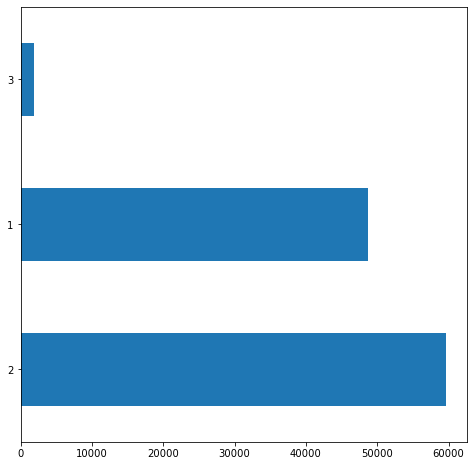

In [113]:
df_scoring.home_address.value_counts().plot.barh()

<AxesSubplot:xlabel='home_address'>

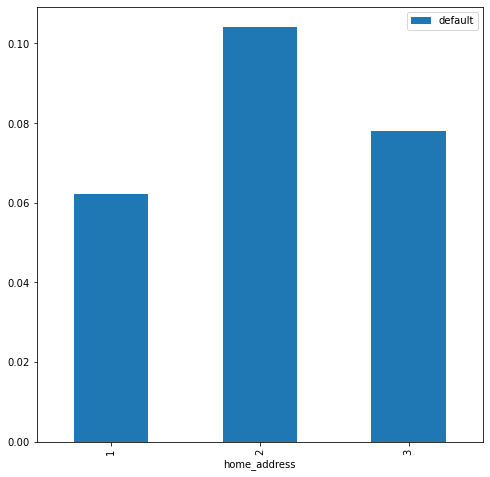

In [114]:
df_scoring.pivot_table(values = ['default'], 
               index = 'home_address', 
               aggfunc = 'mean').plot(kind = 'bar')

In [115]:
home_address = label_encoder.fit_transform(df_scoring['home_address'])
print(dict(enumerate(label_encoder.classes_)))

{0: 1, 1: 2, 2: 3}


### Рассмотрим и проанализируем колонку work_address

In [116]:
df_scoring['work_address'].value_counts()

3    67113
2    30761
1    12274
Name: work_address, dtype: int64

<AxesSubplot:>

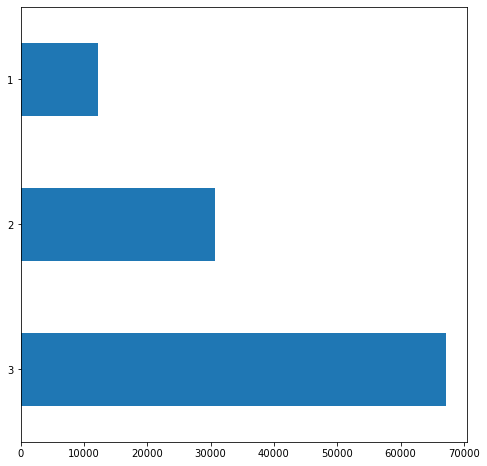

In [117]:
df_scoring.work_address.value_counts().plot.barh()

Пропусков нет

### Рассмотрим и проанализируем колонку sna

In [118]:
#sna - связь заемщика с клиентами банка

In [119]:
df_scoring['sna'].value_counts()

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

### Рассмотрим и проанализируем колонку first_time

In [120]:
# first_time - давность наличия информации о заемщике

In [121]:
df_scoring['first_time'].value_counts()

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

<AxesSubplot:>

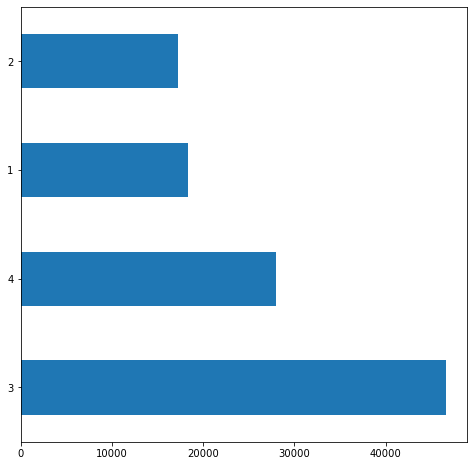

In [122]:
df_scoring['first_time'].value_counts().plot.barh()

<AxesSubplot:xlabel='first_time'>

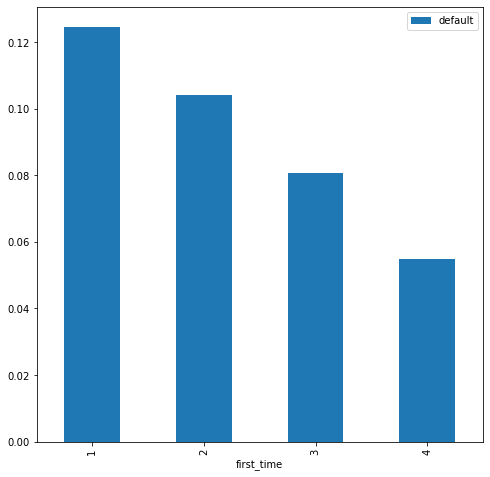

In [123]:
df_scoring.pivot_table(values = ['default'], 
               index = 'first_time', 
               aggfunc = 'mean').plot(kind = 'bar')

## Рассмотрим и проанализируем бинарные переменные в колонках bin_cols

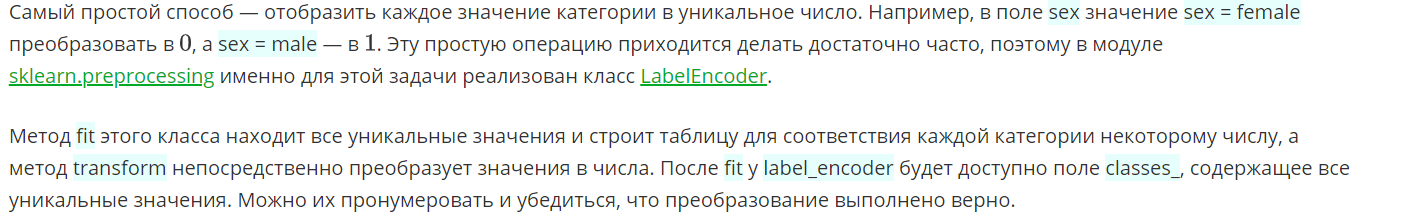

Применим LabelEncoder ко всему набору бинарных переменных.

In [124]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df_scoring[column] = label_encoder.fit_transform(df_scoring[column])
    print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'Y'}
{0: 0, 1: 1}


Почему мы применили метод только к бинарным переменным? Единственным минусом использования кодирования при помощи LabelEncoder() является то, что при использовании этого подхода мы должны быть уверены, что признак не может принимать неизвестных ранее значений. 

→ Что произойдет, если у нас появятся данные с другими категориями? LabelEncoder будет ругаться, что не знает новую категорию. 

Например, если у нас появится новый пол (помимо женского и мужского), признак sex придется обрабатывать по-другому.

Исходя из описания, наши признаки строго бинарные (принимают только два значения) и сюрпризов (новых неизвестных значений) быть не должно.

In [125]:
df_scoring

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,day,month,year,date_diff,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,education_UNKN
0,74835,2014-03-22,1,-0.889859,1,1,0.000000,0,-2.271884,3,...,5,3,2014,2907,0,1,0,0,0,0
1,17527,2014-01-24,0,-0.021654,0,0,0.151515,0,-1.504999,2,...,4,1,2014,2964,0,0,0,1,0,0
2,75683,2014-03-23,1,0.933372,1,1,0.000000,0,-1.691339,1,...,6,3,2014,2906,0,0,0,0,1,0
3,26883,2014-02-03,1,1.454295,0,0,0.000000,0,-2.374182,1,...,0,2,2014,2954,0,0,0,1,0,0
4,28862,2014-02-04,0,-0.108474,0,0,0.000000,0,-2.487502,0,...,1,2,2014,2953,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,2014-03-04,0,0.499269,0,0,0.000000,0,-1.792064,3,...,1,3,2014,2925,0,1,0,0,0,0
110144,76821,2014-03-24,1,0.151987,1,1,0.000000,0,-2.058029,1,...,0,3,2014,2905,0,0,0,1,0,0
110145,103695,2014-04-22,1,-0.716218,0,0,0.000000,0,-1.512635,4,...,1,4,2014,2876,0,0,0,1,0,0
110146,861,2014-01-04,0,-0.889859,0,0,0.000000,1,-1.479334,3,...,5,1,2014,2984,0,0,0,1,0,0


In [126]:
cat_cols.remove('education')
cat_cols.extend(['education_ACD', 'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR', 'education_UNKN'])

<b>ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ И БИНАРНЫХ ПРИЗНАКОВ</b>

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

<AxesSubplot:>

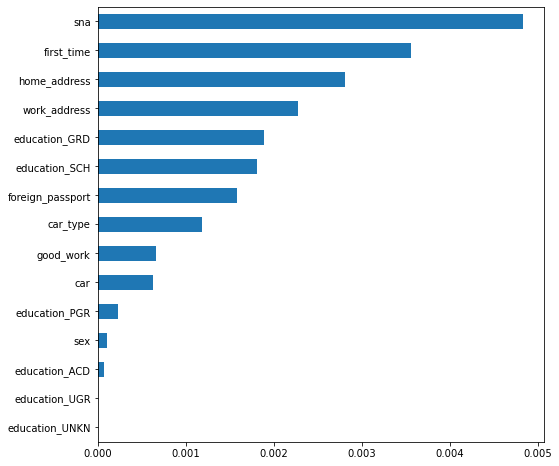

In [127]:
imp_cat = Series(mutual_info_classif(df_scoring[bin_cols + cat_cols], df_scoring['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<b>Cамый важный признак из категориальных - sna</b>

<AxesSubplot:>

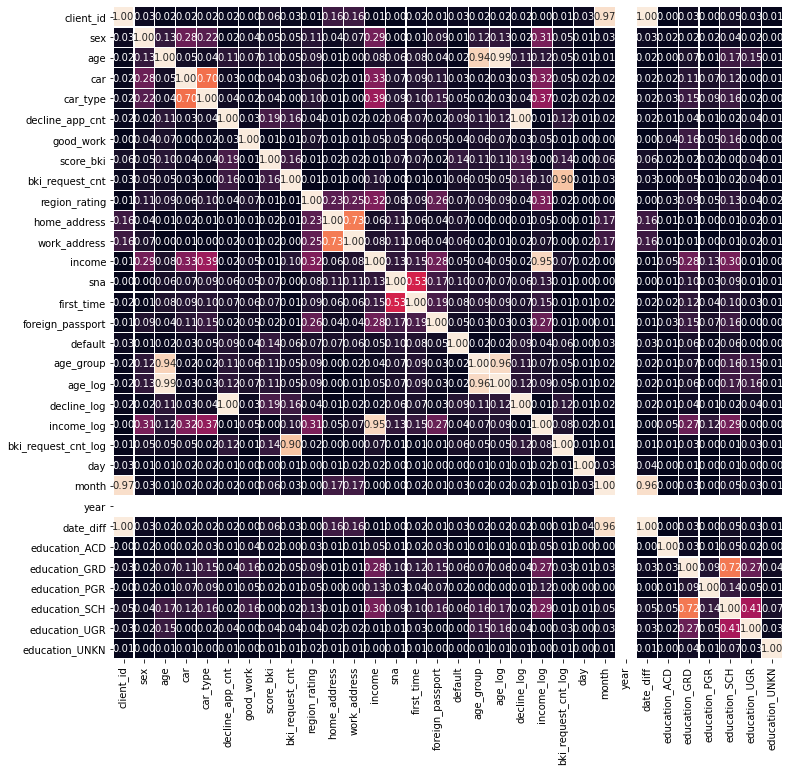

In [128]:
plt.rcParams['figure.figsize'] = (12,12)
sns.heatmap(df_scoring.drop(['sample'], axis=1).corr().abs(),annot=True, fmt=".2f", linewidths=0.1, cbar=False)


Сильная корреляция наблюдается между: 
- car и car_type - (0.70), удаляем car
- рабочим и домашним адресами - (0.73) удалим рабочий адрес work_address
- client_id, month, day - (1,0.96) оставим одну из них (month)
- между доходом и наличем загран.паспорта - (0.28)
- между полом и наличием машины (0,28)
- между доходом и рейтингом региона, галичием машины (0,31, 0,32)
- из age age_group оставим age
- между sna и first_time - (0.53)
- столбец year вообще уберем
- сильная корреляция между логарифмированными и изначальными признаками

In [129]:
num_cols.remove('year')

In [130]:
final_cols=cat_cols
final_cols.extend(num_cols)
final_cols.extend(bin_cols)
len(final_cols)

25

In [131]:
final_cols = list(set(final_cols) - {'car', 'work_address', 'age_group','app_date'})

## Создание полиномиальных признаков

In [132]:
#Создадим признаки на основе двух хорошо скоррелированных колонок
poly = PolynomialFeatures(2)
poly.fit_transform(X)
pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(df_scoring[['score_bki', 'sna', 'first_time']])
poly_features.shape

(110148, 10)

In [133]:
df_scoring=pd.concat([df_scoring, pd.DataFrame(poly_features)], axis=1)

In [134]:
poly_cols=[1,2,3,4,5,6,7,8,9]

In [135]:
final_cols.extend(poly_cols)

# Data Preprocessing

In [136]:
df_preproc = df_scoring.copy()

In [137]:
train_proc = df_preproc.query('sample == 1').drop(['sample'], axis=1)
valid_proc = df_preproc.query('sample == 0').drop(['sample'], axis=1)

In [138]:
train_proc[final_cols]

,bki_request_cnt_log,income,region_rating,education_ACD,score_bki,car_type,education_UGR,month,day,good_work,...,education_PGR,1,2,3,4,5,6,7,8,9
36349,0.693147,18000.0,50,0,-2.008753,1,0,2,5,0,...,0,-2.008753,4.0,1.0,4.035088,-8.035012,-2.008753,16.0,4.0,1.0
36350,1.386294,19000.0,50,0,-1.532276,0,0,3,2,0,...,0,-1.532276,4.0,1.0,2.347870,-6.129105,-1.532276,16.0,4.0,1.0
36351,0.693147,30000.0,80,0,-1.408142,0,0,2,5,0,...,0,-1.408142,1.0,4.0,1.982865,-1.408142,-5.632569,1.0,4.0,16.0
36352,1.098612,10000.0,50,0,-2.057471,0,0,1,3,0,...,0,-2.057471,1.0,3.0,4.233188,-2.057471,-6.172414,1.0,3.0,9.0
36353,0.693147,30000.0,60,0,-1.244723,0,0,4,4,1,...,0,-1.244723,1.0,4.0,1.549335,-1.244723,-4.978891,1.0,4.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,1.386294,17000.0,50,0,-1.792064,0,0,3,1,0,...,0,-1.792064,4.0,4.0,3.211495,-7.168257,-7.168257,16.0,16.0,16.0
110144,0.693147,70000.0,50,0,-2.058029,1,0,3,0,0,...,0,-2.058029,1.0,4.0,4.235484,-2.058029,-8.232117,1.0,4.0,16.0
110145,1.609438,45000.0,80,0,-1.512635,0,0,4,1,0,...,0,-1.512635,2.0,2.0,2.288064,-3.025269,-3.025269,4.0,4.0,4.0
110146,1.386294,13000.0,50,0,-1.479334,0,0,1,5,1,...,0,-1.479334,2.0,3.0,2.188428,-2.958668,-4.438001,4.0,6.0,9.0


In [139]:
# Разделим данные для обучения на тренировочную и валидационную части
X = train_proc[final_cols].values
y = train_proc['default']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
X_test = valid_proc[final_cols]

In [140]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [141]:
# Обучаем модель
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)


y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)

### Оценка качества модели

В качестве методов оценки прогностической способности модели используем ROC-анализ.
Классификатор имеет параметр порог отсечения. Изменяя его значение, мы получаем то или иное разбиение на два класса — класс с положительными исходами и класс с отрицательными исходами.

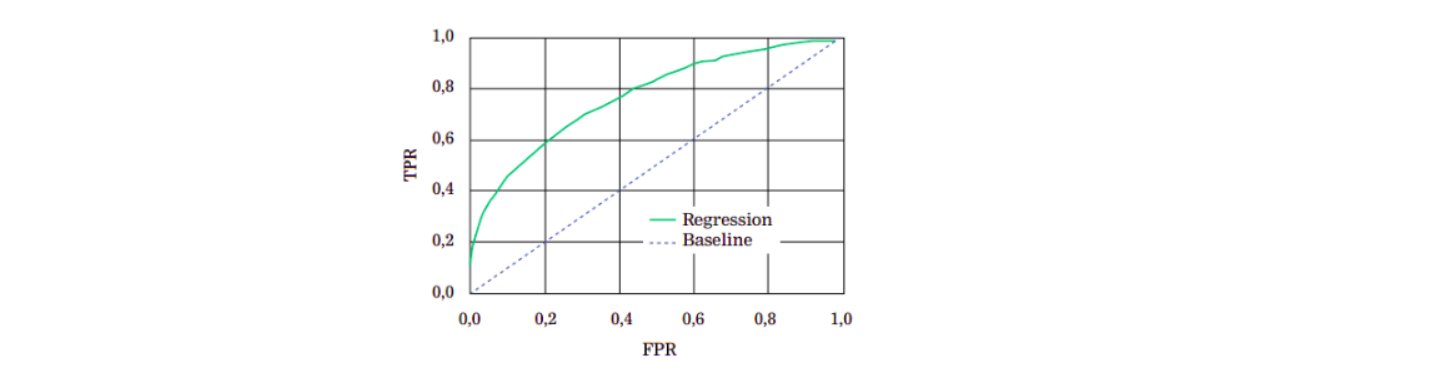

В нашем примере положительным исходом будет наличие дефолта у заемщика, отрицательным — отсутствие дефолта.

precision_score: 0.36363636363636365
recall_score: 0.01532567049808429
f1_score: 0.029411764705882353

confusion matrix: 
 [[12884    49]
 [ 1799    28]]

Предсказано невозращение кредита клиентом, по факту вернувшим кредит: 49 
 или 0.38% от всех вернувших 

Предсказан возврат кредита клиентом, по факту не вернувшим кредит: 1799 
или 98.47% от всех не вернувших


roc_auc_score: 0.7393852219118778


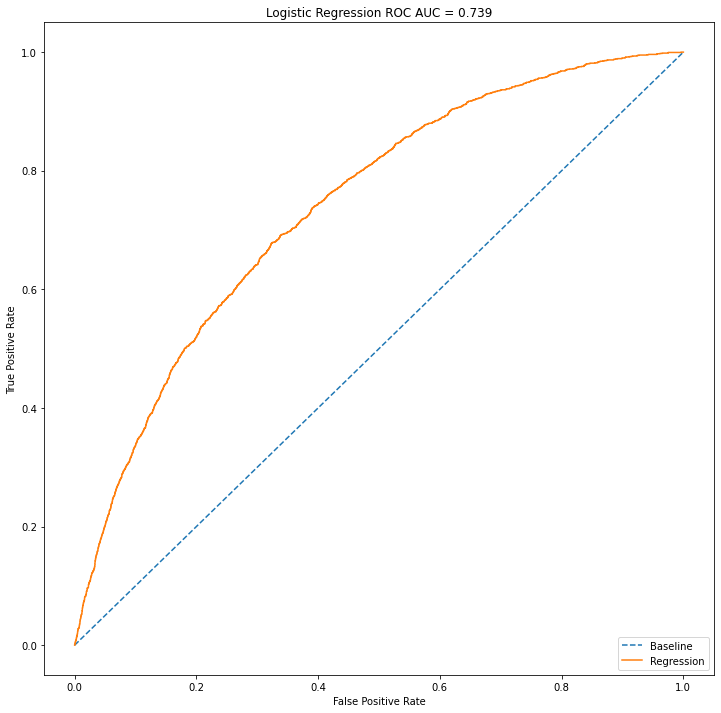

In [142]:
# # Выводим получившиеся метрики

print('precision_score:', precision_score(y_val, y_pred))
print('recall_score:', recall_score(y_val, y_pred))
print('f1_score:', f1_score(y_val, y_pred))
сf_mtx = confusion_matrix(y_val, y_pred)
print()
print('confusion matrix:', '\n', сf_mtx)
tn, fp, fn, tp = сf_mtx.ravel()
print()
print('Предсказано невозращение кредита клиентом, по факту вернувшим кредит: {} \n\
 или {}% от всех вернувших \n'.format(fp, round((fp/(fp+tn))*100, 2)))
print('Предсказан возврат кредита клиентом, по факту не вернувшим кредит: {} \n\
или {}% от всех не вернувших\n'.format(fn, 
                                        round((1-recall_score(y_val,
                                                              y_pred))*100, 2)))
print()
print('roc_auc_score:', roc_auc_score(y_val, y_pred_proba[:, 1]))
fpr, tpr, threshold = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1])
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [143]:
# Матрица ошибок плохая, очень много дефолтных клиентов, неузнанных моделью, попробуем все же сбалансировать и настроить
# гиперпараметры

In [144]:
hyperparameters = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs", "liblinear", "sag", "saga"],
}

model = LogisticRegression(penalty="l2", max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0, scoring="f1")

best_model = clf.fit(X_train, y_train)

print("Лучшее C:", best_model.best_estimator_.get_params()["C"])
print("Лучшей solver:", best_model.best_estimator_.get_params()["solver"])

Лучшее C: 10
Лучшей solver: lbfgs


In [145]:
params = best_model.best_estimator_.get_params()
model = LogisticRegression(**params)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)

precision_score: 0.22361898016997167
recall_score: 0.6912972085385879
f1_score: 0.33792642140468226

confusion matrix: 
 [[8548 4385]
 [ 564 1263]]

Предсказано невозращение кредита клиентом, по факту вернувшим кредит: 4385 
 или 33.91% от всех вернувших 

Предсказан возврат кредита клиентом, по факту не вернувшим кредит: 564 
или 30.87% от всех не вернувших


roc_auc_score: 0.7393852219118778


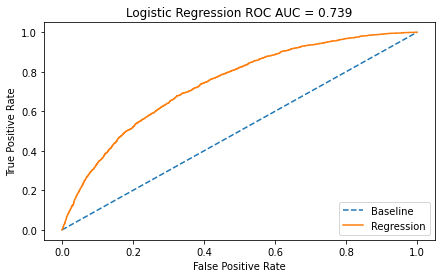

In [146]:
# Выводим получившиеся метрики

print('precision_score:', precision_score(y_val, y_pred))
print('recall_score:', recall_score(y_val, y_pred))
print('f1_score:', f1_score(y_val, y_pred))
сf_mtx = confusion_matrix(y_val, y_pred)
print()
print('confusion matrix:', '\n', сf_mtx)
tn, fp, fn, tp = сf_mtx.ravel()
print()
print('Предсказано невозращение кредита клиентом, по факту вернувшим кредит: {} \n\
 или {}% от всех вернувших \n'.format(fp, round((fp/(fp+tn))*100, 2)))
print('Предсказан возврат кредита клиентом, по факту не вернувшим кредит: {} \n\
или {}% от всех не вернувших\n'.format(fn, 
                                        round((1-recall_score(y_val,
                                                              y_pred))*100, 2)))
print()
print('roc_auc_score:', roc_auc_score(y_val, y_pred_proba[:, 1]))
fpr, tpr, threshold = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1])
plt.figure(figsize=(7, 4))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

С балансировкой матрица ошибок выглядит намного лучше и коэффициенты тоже. Оставляем этот вариант для финального предсказания.

In [147]:
#с деревом решений не очень хорошие результаты
#tree = DecisionTreeClassifier(max_depth=100, random_state=456)
#tree.fit(X_train, y_train)
#y_pred = tree.predict(X_val)
#y_pred_proba = tree.predict_proba(X_val)

In [148]:
#cat = CatBoostClassifier(n_estimators=1000, depth=10, logging_level='Silent')
#cat.fit(X_train, y_train)
#y_pred = cat.predict(X_val)
#y_pred_proba = cat.predict_proba(X_val)
#roc auc улучшилось, матрица ошибок ухудшилась

# Submission

In [149]:
y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred_test = model.predict(X_test)

submission = df_test[["client_id"]].copy()
submission["default"] = y_proba_test
submission.to_csv("submission.csv", index=False)
display(submission.sample(10))

,client_id,default
647,5429,0.324095
5477,68915,0.113071
26882,35212,0.531927
8468,66323,0.723325
29795,62479,0.314732
27459,59062,0.319885
20939,89,0.412044
5449,2175,0.474517
3940,94392,0.712005
2199,39404,0.536947


In [150]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  36349 non-null  int64  
 1   default    36349 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 568.1 KB
